In [6]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler
col_names = ['x_1','x_2','y']

data = pd.read_csv("ds1_train.csv", skiprows=1, header=None, names=col_names)
data['x_2'] = np.log(data['x_2'])
threshold = 2.2

# Remove outliers from the first two columns and keep the last column unchanged
filtered_rows = (abs(data['x_1'] -data['x_1'].mean()) <= threshold * data['x_1'].std()) & \
                (abs(data['x_2'] - data['x_2'].mean()) <= threshold * data['x_2'].std())
data = data[filtered_rows]
data1= pd.read_csv("ds1_test.csv", skiprows=1, header=None, names=col_names)
data1['x_2']=np.log(data1['x_2'])
data.head(10)
print(len(data))

757


In [7]:
class Node():
    def __init__(self,f_index=None,threshold=None,left=None,right=None,*,value=None):
        self.f_index=f_index
        self.left=left
        self.right=right
        self.threshold=threshold
        self.value=value
    def is_leaf(self):
            return self.value is not None
        

In [8]:
class Descison_Tree():
    def __init__(self,depth=5,min_split=3,n_features=None):
        self.depth=depth
        self.min_split=min_split
        self.n_features=n_features
        self.root=None
    def fit(self,dataset):
        X=dataset[:,:-1]
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root=self.build(dataset)
    def build(self,dataset,cur_depth=0):
        X=dataset[:,:-1]
        Y=dataset[:,-1]
        n_labels=len(np.unique(Y))
        n_sample,n_feats=np.shape(X)
        if (n_sample<self.min_split or n_labels==1 or cur_depth>=self.depth):
             lv=self.mcl(Y)
             return Node(value=lv)
        feat_idx=np.random.choice(n_feats,self.n_features,replace=False)
        best_threshold,best_features=self.best_split(feat_idx,dataset)
        X_col=X[:,best_features]
        l_i,r_i=self.split(X_col,best_threshold)
        left=self.build(dataset[l_i,:],cur_depth+1)
        right=self.build(dataset[r_i,:],cur_depth+1)
        return Node(best_features,best_threshold,left,right)
    
    def best_split(self,feat_idx, dataset):
        best_gain = -1        
        X = dataset[:, :-1]
        Y = dataset[:, -1]
        idx, thr = None, None
        parent_entropy = self.entropy(Y)
        
        for i in feat_idx:
            X_col = X[:, i]
            unique_values = np.unique(X_col)
            
            for j in unique_values:
                mask = X_col <= j
                left_dataset = dataset[mask]
                right_dataset = dataset[~mask]
                
                gain = self.info_gain(left_dataset[:, -1], right_dataset[:, -1],parent_entropy)
                if gain > best_gain and gain > 0.01:
                    idx = i
                    thr = j
                    best_gain = gain

        return thr, idx
    def info_gain(self,left_labels, right_labels,parent_entropy):
      total_samples = len(left_labels) + len(right_labels)
      if len(left_labels)==0 or len(right_labels)==0:
          return 0
      p_left = len(left_labels) / total_samples
      p_right = len(right_labels) / total_samples
    
      return parent_entropy -(p_left * self.entropy(left_labels) + p_right *self. entropy(right_labels))
    def mcl(self,Y):
        counter = Counter(Y)
        value = counter.most_common(1)[0][0]
        return value
        
    def split(self,X_col,j):
        l_i=np.where(X_col<=j)
        r_i=np.where(X_col>j)
        l_i=l_i[0].tolist()
        r_i=r_i[0].tolist()
        return l_i,r_i
        
    def entropy(self,Y):
        Y=Y.astype("int64")
        _, counts = np.unique(Y, return_counts=True)
        ps = counts / len(Y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])
    
    def predict(self,X):
        return np.array([self.traverse(x,self.root) for x in X])
    def traverse(self,x,node):
        if node.is_leaf():
            return node.value
        if x[node.f_index]<node.threshold:
            return self.traverse(x,node.left)
        return self.traverse(x,node.right)
    

In [9]:
Dt=Descison_Tree(depth=5 ,min_split=5)
Dt.fit(np.array(data))
data1=np.array(data1)
X=data1[:,:-1]
y_true=data1[:,-1]
y_pred=Dt.predict(X)
print(f1_score(y_pred,y_true))
print(accuracy_score(y_pred,y_true))

0.8823529411764707
0.88


In [10]:
costy=[]


def HyperTune(evaluation):
    p1,p2=0,0
    c=.01
    for i in range(1,9):
        acc=0
        for k in range(2,9):
            for j in range(0,5):
                data_temp=data
                random_row = data_temp.sample(n=650)
                rest= data_temp.drop(random_row.index).reset_index(drop=True)
                random_row.reset_index(drop=True,inplace=True)
                rest.reset_index(drop=True,inplace=True)
                d1=data_temp
                data_temp=np.array(d1)
                rest=np.array(rest)
                DT=Descison_Tree(min_split=i,depth=k)
                DT.fit(data_temp)
                y_pred=DT.predict(rest[:,:-1])
                y_true=rest[:,-1]
                if evaluation=='f1score':
                    p=f1_score(y_pred,y_true)
                else:
                    p=accuracy_score(y_pred,y_true)
                acc+=p
            cost1=acc/5
            acc=0
            if c<cost1:
                c=cost1
                p1=i
                p2=k
            costy.append(cost1)
    return p1,p2


In [11]:
print(HyperTune("f1score"))

(5, 7)


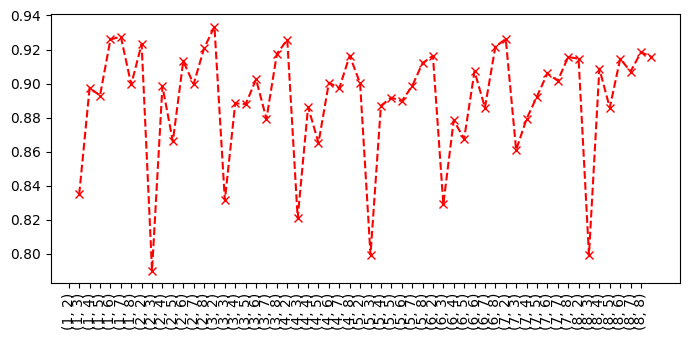

In [29]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x=[]
for i in range(1,9):
    for j in range(2,9):
        x.append((i,j))
y3 = costy
default_x_ticks = range(len(x))
plt.plot(range(1, len(x) + 1), y3, marker='x', linestyle='--', color='r', label='List Data')
plt.xticks(default_x_ticks, x,rotation='vertical')
plt.show()

In [35]:
Dt=Descison_Tree(depth=5 ,min_split=7)
data=np.array(data)
Dt.fit(data)
data1=np.array(data1)
X=data1[:,:-1]
y_true=data1[:,-1]
y_pred=Dt.predict(X)
print(f1_score(y_pred,y_true))
print(accuracy_score(y_pred,y_true))


0.8910891089108911
0.89


In [28]:
#tunning by dividing X_train into a validation and training data and evalutaion 5 times and taking average


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
None


In [150]:
from sklearn.tree import DecisionTreeClassifier
tree_classifier = DecisionTreeClassifier(random_state=42)
X_train=data[:,:-1]
Y_train=data[:,-1]
tree_classifier.fit(X_train,Y_train)

DecisionTreeClassifier(random_state=42)

In [151]:
y_pred = tree_classifier.predict(X)

In [153]:
print(accuracy_score(y_pred,y_true))

0.88
